In [4]:
import numpy as np
import pandas as pd
import torch 

import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime, timedelta

import itertools
from torch.optim import Adam
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset,DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import warnings
warnings.filterwarnings("ignore")

from collections import deque
import numpy as np
from scipy.stats import t
from scipy.optimize import minimize

COLOR_RED = "\033[91m"
COLOR_GREEN = "\033[92m"
COLOR_YELLOW = "\033[93m"
COLOR_BLUE = "\033[94m"
COLOR_CARMINE = "\033[95m"
COLOR_CYAN = "\033[96m"
COLOR_WHITE = "\033[97m"

BACKGROUND_RED = "\033[41m"
BACKGROUND_GREEN = "\033[42m"
BACKGROUND_YELLOW = "\033[43m"
BACKGROUND_BLUE = "\033[44m"
BACKGROUND_CARMINE = "\033[45m"
BACKGROUND_CYAN = "\033[46m"
BACKGROUND_WHITE = "\033[47m"

STYLE_BOLD = "\033[1m"
STYLE_UNDERLINE = "\033[4m"
STYLE_REVERSE = "\033[7m"
COLOR_RESET = "\033[0m"

Matplotlib created a temporary cache directory at /tmp/matplotlib-siydtzcc because the default path (/work/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
atten = np.load('data/attendance.npy')

In [9]:
def count_continuous_nonzero(row):
    count = 0
    zero_count = 0
    ct_list, zct_list = [], []

    for value in row:
        if value != 0:
            count += 1
        else:
            if count == 0:
                continue
            else:
                ct_list.append(count)
                count = 0
    if count != 0:
        ct_list.append(count)
    
    for value in row:
        if value == 0:
            zero_count += 1
        else:
            if zero_count == 0:
                continue
            else:
                zct_list.append(zero_count)
                zero_count = 0
    if zero_count != 0:
        zct_list.append(zero_count)
        
    return ct_list, zct_list

def avg_atten(x,window_size,disp = False):
    gps = []
    for i in range(x.max()):
        gps.append(len(x[x == i]))
    gps = np.array(gps)

    window = np.ones(window_size) / window_size
    smoothed_data = np.convolve(gps, window, mode='same')
    if disp:
        plt.plot(gps,label = 'origin')
        plt.plot(smoothed_data,label='smooth')
        plt.legend()
    ret = []
    for i,num in enumerate(smoothed_data):
        ret+= [i+1] * int(num)
    return np.array(ret)

In [13]:
def avg_atten(x,window_size):
    gps = []
    for i in range(x.max()):
        gps.append(len(x[x == i]))
    gps = np.array(gps)

    window = np.ones(window_size) / window_size
    smoothed_data = np.convolve(gps, window, mode='same')
    # plt.plot(gps,label = 'origin')
    # plt.plot(smoothed_data,label='smooth')
    # plt.legend()
    ret = []
    for i,num in enumerate(smoothed_data):
        ret+= [i+1] * int(num)
    return np.array(ret)

def sample(df, loc, scale, size, boundary, individual_sample, importance = 10, prior_ratio = 0.6):
    generated_sample =  np.repeat(individual_sample, repeats=importance)
    prior_size = len(generated_sample)
    sample_size = size-prior_size
    weight = np.concatenate([np.ones(prior_size) * prior_ratio / prior_size,
                             np.ones(sample_size) * (1-prior_ratio) / sample_size])

    while len(generated_sample) <  size :
        temp_size = size - len(generated_sample)
        new_sample = t.rvs(df=df, loc=loc, scale=scale, size=temp_size)
        new_sample = new_sample[(new_sample>=boundary[0]) & (new_sample<=boundary[1])]
        generated_sample = np.concatenate((generated_sample, new_sample))
        
    return generated_sample[:size],weight

def count_continuous(arr):
    count_zeros = np.zeros(arr.shape[0])
    count_ones = np.zeros(arr.shape[0])

    for i in range(arr.shape[0]):
        data = arr[i, ::-1]
        if data.mean() == 0:
            count_zeros[i] = len(data)
            continue
        elif data.mean() == 1:
            count_ones[i] = len(data)
            continue

        if data[0] == 0:
            count_zeros[i] = np.argwhere(data == 1).min()
        else:
            count_ones[i] = np.argwhere(data == 0).min()
    return count_ones,count_zeros

def fetch_init(x,period = 30, n =1):
    ret = []
    for i in range(n):
        _,t = x.shape
        start = int(random.random()*(t-2*period))
        atten_t = x[:,start+period:start+2*period].sum(axis=0)
        continual_atten, continual_absen = count_continuous(x[:,:start+period])
        ret.append(torch.Tensor(np.concatenate([atten_t, continual_atten, continual_absen])))
        
    return torch.stack(ret,dim=0)

In [5]:
individual_continuous_atten, individual_continuous_absence, collective_continuous_atten, collective_continuous_absence = [], [], [], []
for at in atten:
    cat, cab = count_continuous_nonzero(at)
    individual_continuous_atten.append(cat)
    individual_continuous_absence.append(cab)
    collective_continuous_atten +=cat
    collective_continuous_absence += cab

individual_continuous_atten = [np.array(item).astype(int) for item in individual_continuous_atten]
individual_continuous_absence = [np.array(item).astype(int) for item in individual_continuous_absence]

collective_continuous_atten = np.array([np.array(item).astype(int) for item in collective_continuous_atten])
collective_continuous_absence =np.array([np.array(item).astype(int) for item in collective_continuous_absence])

In [15]:
def log_likelihood(params,data,lower_bound, upper_bound,weight =None):
    df, loc, scale = params
    ratio = t.cdf(upper_bound,df,loc,scale) - t.cdf(lower_bound,df,loc,scale)
    pdf = t.pdf(data, df, loc, scale) / ratio
    if weight is None:
        log_likelihood = np.mean(np.log(pdf))
    else:
        log_likelihood = np.mean(np.log(pdf*weight))
    return -log_likelihood

Estimated degrees of freedom (df): 2.4280336734540837
Estimated location parameter (loc): 6.296287247274702
Estimated scale parameter (scale): 12.896392438720923


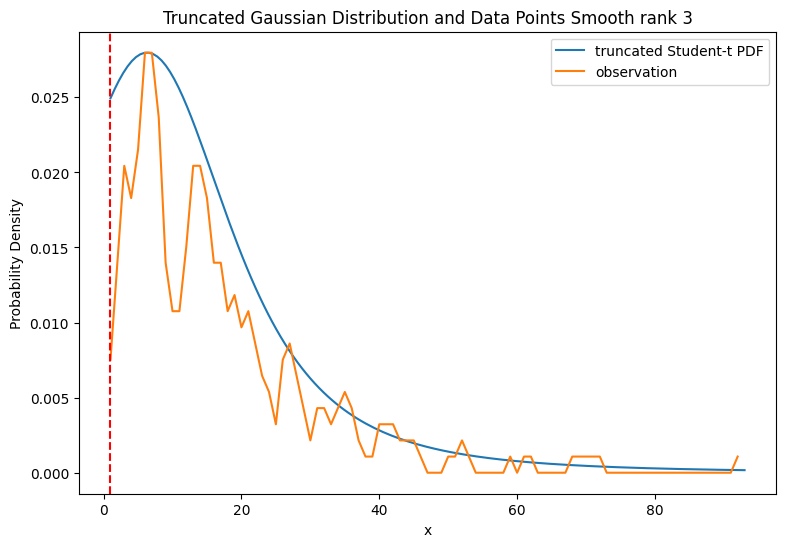

In [16]:
init = [2,6,12] #df, loc, scale
smooth_rank = 3
data =  avg_atten(collective_continuous_atten,smooth_rank) # 
lower_bound, upper_bound = data.min(), data.max()

result = minimize(log_likelihood, x0=init, args = (data,lower_bound,upper_bound), method = 'Nelder-Mead')

prior_df, prior_loc, prior_scale = result.x

print("Estimated degrees of freedom (df):", prior_df)
print("Estimated location parameter (loc):", prior_loc)
print("Estimated scale parameter (scale):", prior_scale)

x = np.linspace(lower_bound, upper_bound, 150)
y = t.pdf(x, prior_df, prior_loc, prior_scale)

plt.figure(figsize=(9,6))
plt.plot(x, y, label='truncated Student-t PDF')

li = []
for i in range(int(upper_bound)):
    li.append(len(data[data == i]))
li_sum=np.array(li)[1:]
plt.plot(np.arange(1,int(upper_bound)),li_sum/li_sum.max()*y.max(),label='observation')
plt.title(f'Truncated Gaussian Distribution and Data Points Smooth rank {smooth_rank}')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.axvline(x=1, color='r', linestyle='--')
plt.legend()
plt.show()

In [10]:
# bayes bootsrapping
defaultsize = 2000
bootstrap_times = 3

individual_distribution = []

for at in individual_continuous_atten:
    df, loc, scale= prior_df, prior_loc, prior_scale

    for _ in range(bootstrap_times):
        data,weight = sample(df, loc, scale, defaultsize, [lower_bound, upper_bound], np.array([at]))
        result = minimize(log_likelihood, x0=init, args = (data,lower_bound,upper_bound,weight), method = 'Nelder-Mead')
        df, loc, scale= result.x
    individual_distribution.append([df, loc, scale])

In [99]:
def fetch_init(x,period,n, samples,device):
    ret_list =[]
    for i in range(samples):
        _,t = x.shape
        start = int(random.random()*(t-2*period))
        atten_t = x[:,start+period:start+2*period].sum(axis=0)
        continual_atten, continual_absen = count_continuous(x[:,:start+period])
        time_index = np.zeros(len(atten_t))
        courier_index = np.zeros(n)
        time_index[0] = 1
        ret = torch.Tensor(np.concatenate([atten_t,time_index, continual_atten, continual_absen, courier_index]))
        ret = ret.unsqueeze(0).unsqueeze(0).repeat(1,n,1)
        for i in range(n):
            ret[:,i,-(n-i)]=1
        ret_list.append(ret)
    return torch.cat(ret_list,dim=0).to(device),torch.Tensor([0]).to(device)

def eval(env,actor,t,initial =None):
    if initial is None:
        state,_ = fetch_init(atten,num_t,num_agents,batch_size,torch.device('cuda:0'))
    else:
        state = initial
    done = torch.Tensor([0])
    probs,actions =[],[]
    inits = state
    while not done.sum():
        observe = env.observe(state)
        prob = actor.forward(observe)
        _,action = actor.select_action(observe)
        next_state, _, done = env.step(action,state)
        state = next_state
        probs.append(prob[0])
        actions.append(action[0])

    probs = torch.stack(probs,axis=1)
    actions = torch.stack(actions,axis=1)

    plt.figure(figsize=(6,4))
    plt.plot(actions.sum(axis=0).cpu().detach(),label ='allocate')
    plt.plot(inits[0,0,:t].cpu().detach(),label ='GT')
    plt.ylim(15,32)
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    for i in range(30):
        plt.plot(probs[i,:].cpu().detach())
    plt.plot(inits[0,0,:t].cpu().detach()/31,label ='GT_prob',linewidth =2,c='black')
    plt.legend()
    plt.show()
    return probs


In [83]:
class Environment():
    def __init__(self,couriers,time,continual_atten_distr,lower_bound, upper_bound,device):
        super(Environment, self).__init__()
        self.t = time
        self.n = couriers
        self.device = device
        self.continual_atten_distr = continual_atten_distr
        self.min =[15,1,0]
        self.max =[31,50,10]

        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        
        ratio =[]
        for courier_id in range(self.n):
            df,loc,scale = self.continual_atten_distr[courier_id]
            r = t.cdf(self.upper_bound,df,loc,scale) - t.cdf(self.lower_bound,df,loc,scale)
            ratio.append(r) 
        self.ratio = torch.Tensor(ratio)
    
    def observe(self, states, full = False):
        marginal_atten = states[...,:self.t]# B,D
        time_index = states[...,self.t:self.t*2]# B,D
        conse_atten = states[...,self.t*2:self.t*2+self.n]# B,D
        conse_absen = states[...,self.t*2+self.n:self.t*2+self.n*2] # B,D
        courier_index = states[...,self.t*2+self.n*2:] # B,N,D
        
        marginal_atten_norm = (marginal_atten -self.min[0])/(self.max[0]-self.min[0])
        sums = (time_index * marginal_atten_norm).sum(axis=-1).unsqueeze(-1)
        conse_atten = (conse_atten-self.min[1])/(self.max[1]-self.min[1])
        conse_absen = (conse_absen-self.min[2])/(self.max[1]-self.min[2])
    
        normed_state = torch.cat([sums,conse_atten,courier_index],dim=-1)
        if full:
            normed_state = torch.cat([marginal_atten_norm,time_index,conse_atten,courier_index],dim=-1)
        return normed_state

    def step(self, actions, states, scaler = [1,50,5], delayed = False):
        with torch.no_grad():
            actions, states = actions.cpu(), states.cpu()

            # B,N,2T+3N
            marginal_atten = states[...,0,:self.t]                 # B,T
            time_index = states[...,0,self.t:self.t*2]             # B,T
            conse_atten = states[...,0,self.t*2:self.t*2+self.n]   # B,N
            conse_absen = states[...,0,self.t*2+self.n:self.t*2+self.n*2] # B,N  
            courier_index = states[...,self.t*2+self.n*2:]         # B,N,N
            
            bs = actions.shape[0]
            next_states = torch.zeros(bs,self.t*2+self.n*2)
            collective_rewards = torch.zeros(bs,self.n)
            individual_rewards = torch.zeros(bs,self.n)
            dones = torch.zeros(bs)

            for i in range(bs):
                total_atten = (marginal_atten[i] * time_index[i]).sum() 
                collective_rewards[i,:] = - torch.mean((total_atten-actions[i].sum())**2) * scaler[0] 

                at_courier = torch.where(conse_atten[i] != 0)[0]
                for courier_id in at_courier:
                    df,loc,scale = self.continual_atten_distr[courier_id]
                    prob = t.pdf(conse_atten[i][courier_id], df,loc,scale) / self.ratio[courier_id]
                    
                    individual_rewards[i,courier_id]+=prob * scaler[1] # reward_cat

                # update state
                conse_atten[i] += actions[i]
                conse_atten[i] *= actions[i] 

                conse_absen[i] += 1-actions[i]
                conse_absen[i] *= (1-actions[i])

                current_bit = torch.where((time_index[i] != 0))[0]
                time_index[i][current_bit] = 0

                if current_bit == self.t-1:
                    dones[i] = 1
                else:
                    dones[i] = 0
                    time_index[i][current_bit+1] = 1
                next_states[i] = torch.cat([marginal_atten[i],time_index[i],conse_atten[i],conse_absen[i]])
            next_states = torch.cat([next_states.unsqueeze(1).repeat(1,self.n,1),courier_index],axis=-1)
            rewards = collective_rewards + individual_rewards
        return next_states.to(self.device), rewards.to(self.device), dones.unsqueeze(-1).to(self.device)


In [84]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return torch.cat(states,dim=0),torch.cat(actions,dim=0),torch.cat(rewards,dim=0), torch.cat(next_states,dim=0), torch.cat(dones,dim=0)

In [149]:
#actor-critic  

class PolicyNetwork(nn.Module):
    def __init__(self,n,t):
        super(PolicyNetwork, self).__init__()
        self.hidden_dim = 16
        self.layer = nn.Sequential(
            nn.Linear(n*2+1,self.hidden_dim *2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim *2,self.hidden_dim),
        ) #
        self.q = nn.Linear(self.hidden_dim,self.hidden_dim)
        self.k = nn.Linear(self.hidden_dim,self.hidden_dim)
        self.v = nn.Linear(self.hidden_dim,self.hidden_dim)

        self.output = nn.Sequential(
            nn.Linear(self.hidden_dim,1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        # x: sum + individual atten
        hidden = self.layer(x) # bnd

        q = self.q(hidden)
        k = self.k(hidden)
        v = self.v(hidden)
        scores = nn.functional.softmax(torch.matmul(q,k.transpose(1,2)),dim=1)

        attended = torch.matmul(scores,v)
        prob = self.output(attended).squeeze(-1)
        return prob
    
    def select_action(self,x):
        action_probs = self.forward(x)
        dist = torch.distributions.Bernoulli(action_probs)
        action = dist.sample().squeeze(-1)
        logprob = dist.log_prob(action)
        return logprob, action
    
class ValueNetwork(nn.Module):
    def __init__(self,n,t):
        super(ValueNetwork, self).__init__()
        self.hidden_dim = 16
        self.layer = nn.Sequential(
            nn.Linear(n*2+t*2,self.hidden_dim *2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim *2,1),
        )
    def forward(self, x):
        return self.layer(x).squeeze(-1)

In [ ]:
num_episodes = 300
num_agents = 31
num_t = 30
gamma = 0.9
scaler = [1,200,0]
batch_size = 4
# disp_ep =30

device = torch.device('cuda:0')
actor = PolicyNetwork(num_agents,num_t).to(device)
critic = ValueNetwork(num_agents,num_t).to(device)

env = Environment(num_agents,num_t,individual_distribution,lower_bound,upper_bound,device)

actor_optimizer = Adam(actor.parameters(),lr=0.002)
critic_optimizer = Adam(critic.parameters(),lr=0.002)

critic_loss_fn = nn.MSELoss()

replay_buffer = ReplayBuffer(200)

for episode in tqdm(range(1,num_episodes+1)):
    # if episode % disp_ep ==0:
    #     print(f'ep:{episode}-scaler:{scaler}')
    #     eval(env,actor,num_t)
    states,dones = fetch_init(atten,int(random.random()*(num_t)+15),num_agents,batch_size,device)

    while not dones.sum():
        # simulate
        logprobs,actions = actor.select_action(env.observe(states))
        next_states, rewards, dones = env.step(actions,states,scaler =scaler)

        values = critic(env.observe(states,full=True))
        next_values = critic(env.observe(next_states,full=True))
        advantages = rewards + gamma * next_values * (1-dones)
        
        critic_loss = critic_loss_fn(values, advantages)
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        actor_loss = -(logprobs * (advantages - values).detach()).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        states = next_states